**<h1>Práctica computacional: modelo de Ising en 2D</h1>**

El objetivo de la práctica es calcular varios observables (magnetización, energía, susceptibilidad, calor específico) de una red de Ising bidimensional en función de la temperatura, y ver cómo a $T\simeq 2.27$ (usamos unidades en las que $J=k=1$) tiene lugar una transición de fase. También calcularemos la función de correlación y estudiaremos la dependencia de la longitud de correlación con la temperatura. Dado que el número de términos en la función de partición es gigantesco ($2^{100}$ para una red $10\times 10$, algo así como la edad del universo en décimas de picosegundo), no podemos aspirar a calcular la función de partición exactamente. En su lugar, lo que hacemos es generar estados aleatorios de la red distribuidos según el ensamble canónico, y tomar promedios sobre varios de esos estados. Para lograr eso, partimos de un estado inicial cualquiera y le aplicamos el **algoritmo de Metropolis**, que consta de los siguientes pasos:

1.   Elegimos un sitio de la red al azar.
2.   Calculamos la diferencia de energía $\Delta E$ que resultaría de darle vuelta a ese spin.
3. Si $\Delta E\le 0$, le damos vuelta al spin; si $\Delta E>0$, le damos vuelta al spin con probabilidad $e^{-\beta\Delta E}$.

Al estado resultante le volvemos a aplicar el algoritmo, y así sucesivamente. Después de ser iterado muchas veces, el algoritmo empieza a generar estados distribuidos según el ensamble canónico. Tomando promedios sobre varios de esos estados, podremos calcular los observables de interés.










# Bibliotecas

Importamos las bibliotecas de Python que vamos a usar: numpy, que permite definir y operar con matrices, genera números aleatorios, incluye todo tipo de funciones matemáticas, etc; matplotlib.pyplot, que permite hacer gráficos; y numba, que es un compilador que hace que las funciones corran mucho más rápido. También importamos la función curve_fit del paquete scipy.optimize, que nos servirá para hacer ajustes.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

!pip install wget
import wget

from numba import njit
from scipy.optimize import curve_fit
from scipy.stats import linregress

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=40662ec330204bc5982187bc42b1dfcca595c53189eb80c0a9b4d0006a9a58cc
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
wget.download('https://raw.githubusercontent.com/dev-lmmb-phy/Ising-TEO3/main/datos_t_L_16.txt')
wget.download('https://raw.githubusercontent.com/dev-lmmb-phy/Ising-TEO3/main/datos_t_L_32.txt')
wget.download('https://raw.githubusercontent.com/dev-lmmb-phy/Ising-TEO3/main/datos_t_L_64.txt')
wget.download('https://raw.githubusercontent.com/dev-lmmb-phy/Ising-TEO3/main/datos_t_chi_cv.txt')
wget.download('https://raw.githubusercontent.com/dev-lmmb-phy/Ising-TEO3/main/datos_t_lc_30_a.txt')
wget.download('https://raw.githubusercontent.com/dev-lmmb-phy/Ising-TEO3/main/datos_t_lc_30_b.txt')

'datos_t_lc_30_b.txt'

# Funciones

Aquí van a tener que definir dos funciones. La primera, **`h(S)`**, calcula la energía por partícula de la red en el estado **`S`** (nótese que **`S`** es una matriz de $1$'s y $-1$'s). Asumimos que no hay campo magnético y usamos condiciones de contorno periódicas, de manera que el primer spin de una fila/columna es vecino del último. Si la red es $L\times L$, la energía total es entonces

$$H(S)=-\sum_{i,j=1}^L S_{ij}(S_{i-1 j}+S_{ij-1}),$$

y la energía por partícula es esto dividido por $L^2$. La segunda función, **`metropolis(S,prob)`**, aplica el algoritmo de Metropolis al estado **`S`** y devuelve tres cosas: un nuevo estado **`S`**, el incremento de magnetización **`dm`** y el incremento de energía por partícula **`de`**. Deben notar que los únicos valores positivos que puede tomar el incremento de energía $\Delta E$ resultante de dar vuelta a un spin son $\Delta E=4$ y $\Delta E=8$; el argumento **`prob`** es un vector de dos componentes, **`prob[0]`** y **`prob[1]`**, que son las probabilidades con las que daremos vuelta al spin si el incremento de energía es $4$ y $8$ respectivamente. Algunos consejos:


*   Para implementar las condiciones de contorno periódicas, conviene recordar que las listas de Python empiezan con el elemento $0$, el elemento $-1$ es el último, el $-2$ el penúltimo, etc. También les va a ser útil la función **`%`**, que calcula el residuo de la división entre dos enteros (es decir, **`m%n`** es el residuo de la división entre **`m`** y **`n`**).
*   ¡Sean económicos! Para calcular $\Delta E$ no deben calcular la energía total de los dos estados (el estado original y el estado con el spin seleccionado dado vuelta) y restar, sino darse cuenta de que esta cantidad sólo involucra al estado del spin seleccionado y el de sus cuatro primeros vecinos.
*   Para dar vuelta a un spin con probabilidad $p$, lo que hacemos es generar un número aleatorio entre $0$ y $1$ y darle vuelta al spin si ese número es menor que $p$.

Una vez hayan definido estas funciones, primero de todo asegúrense de que andan bien probándolas con una matriz $3\times 3$, por ejemplo tomando **`S=np.ones((3,3))`**. Ahí pueden calcular a mano la energía por partícula y chequear que **`h(S)`** da el resultado correcto. También pueden asegurarse de que, partiendo de esta misma matriz, la funcion **`metropolis(S,prob)`** da vuelta a algún spin más fácilmente a temperaturas altas que a temperaturas bajas, y que los incrementos de magnetización y energía por partícula que calcula son los correctos. Una vez hayan hecho eso, redefinan la función **`metropolis(S,prob)`** de manera que aplique el algoritmo de Metropolis no una sola vez sino tantas como sitios tiene la red. Es decir, su función definitiva debería aplicar el algoritmo al estado original, y después volvérselo a aplicar al estado resultante, y así tantas veces como sitios tiene la red. De vuelta, comprueben que esta función anda bien con una matriz sencilla.

In [ ]:
@njit #Para que numba compile la función
def h(S): #Calcula la energía de la red en el estado S
  H = 0
  L = len(S)
  for i in range(0,L):
    for j in range(0,L):
      H += S[i,j]*(S[i-1,j]+S[i,j-1])
  return -H/L**2

@njit
def metropolis(S,prob): #Aplica el algoritmo de Metropolis al estado S
  L = len(S)

  p = np.random.rand()
  i = np.random.randint(L)
  j = np.random.randint(L)

  dm = -S[i,j]*2/L**2
  delta_e = 2*S[i,j]*(S[(i+1)%L,j] + S[i-1,j] + S[i,(j+1)%L] + S[i,j-1])
  de = delta_e/L**2

  if delta_e <= 0:
    S[i,j]=-S[i,j]
    return(S,dm,de)
  elif delta_e == 4:
    if p > prob[0]:
      return(S,0,0)
    else:
      S[i,j]=-S[i,j]
      return(S,dm,de)
  elif delta_e == 8:
    if p > prob[1]:
      return(S,0,0)
    else:
      S[i,j]=-S[i,j]
      return(S,dm,de)

**Explicación:**

Para armar el algoritmo de Metropolis, verificamos cuánto sería el cambio de energía al tomar un spin $i,j$-ésimo aleatorio y esto arroja 5 posibles resultados. Como la red tiende al equilibrio, si $\Delta E ≤ 0$ entonces el cambio de spin ocurre sin problema alguno. En cambio, para $\Delta E > 0$ tomamos una probabilidad aleatoria $p$ usando NumPy y comparamos con $prob = e^{-4\beta},e^{-8\beta}$ según el caso ($\Delta E=4,8$ respectivamente) para decidir si el cambio ocurre (es decir, si $p < prob$ entonces el cambio ocurre).

# Termalización

Partiendo de un cierto estado inicial, estudiamos cuántos pasos son necesarios para que el sistema llegue al equilibrio, es decir, para que los distintos estados empiecen a estar distribuidos según el ensamble canónico. Para eso, graficamos la magnetización y la energía por partícula en función del paso; el equilibrio se alcanza cuando estas cantidades empiezan a fluctuar alrededor de un valor fijo, en lugar de ser netamente crecientes o decrecientes.
El número de pasos necesarios para alcanzar el equilibrio dependerá de la temperatura, así que hay que hay que hacer el análisis para varias temperaturas. También puede depender del lado de la red, así que cuando cambien el valor de este parámetro van a tener que rehacer este análisis. Fíjense que, cerca de la temperatura crítica, la magnetización oscila entre $1$ y $-1$.

In [ ]:
L=30 #Lado de la red
beta=1

nequilibrio=100000 #Numero de pasos tentativo para llegar al equilibrio

prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

#Estado inicial
#Opcion 1: todos los spines apuntan para arriba
# S=np.ones((L,L),dtype=int)
#Opcion 2: matriz aleatoria de 1's y -1's
S=2*np.random.randint(2,size=(L,L))-1

m=np.zeros(nequilibrio) #magnetización en función del paso
e=np.zeros(nequilibrio) #energia por particula en funcion del paso
m[0]=np.mean(S)
e[0]=h(S)

for n in range(1,nequilibrio):
  S,dm,de=metropolis(S,prob)
  m[n]=m[n-1]+dm
  e[n]=e[n-1]+de

plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.plot(m)
plt.ylabel('magnetizacion')
plt.subplot(2,2,3)
plt.plot(e*(L**2))
plt.ylabel('energia')
plt.xlabel('paso')
plt.subplot(1,2,2)
plt.imshow(S) #plotea el estado final, dandole un color al 1 y otro al -1
plt.show()

NameError: name 'np' is not defined

El código presentado genera con baja frecuencia estados ilógicos a betas altos. Estos
estados consisten de espines completamente alineados a excepción de una banda de espines con orientación opuesta. Estos
casos pueden ser simplemente descartados dado que no se corresponde con estados físicos aceptables. Ocurre generalmente
a valores de β muy altos dado que eso fuerza al algoritmo a
rechazar todos los incrementos de energía. En estos casos, si el espín esta en el centro de una banda
tiene 4 vecinos iguales mientras que si esta en un borde solo
tiene 3. En ambas situaciones la diferencia de energía es positiva
así que se fuerza al algoritmo a ganar una tirada de moneda
de muy baja probabilidad.

# Promedios

Estudiamos cuántos pasos hacen falta para calcular buenos promedios. Para eso, graficamos el valor medio de la magnetización y la energía por partícula en función del número de pasos utilizados para calcularlo (empezando a contar después de haber llegado al equilibrio). Cuando el valor medio se haga constante, el número de pasos será suficiente. De vuelta, el número de pasos apropiado depende de la temperatura y del lado de la red. Van a ver que, cerca de la temperatura crítica, las fluctuaciones se hacen más grandes y por lo tanto es necesario promediar sobre un número más grande de pasos. Para librarnos de las fluctuaciones de la magnetización entre $1$ y $-1$ cerca de la temperatura crítica, que son inmanejables, lo que tomamos es el valor medio de su módulo.

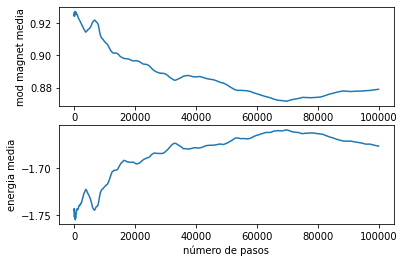

In [ ]:
L=30
beta=1/2.1

nequilibrio=10000000 #Este valor lo decidimos en base a lo anterior
npromedio=100000 #Numero de pasos tentativo para calcular promedios

prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

#S=-np.ones((L,L),dtype=int) #Estado inicial
S=2*np.random.randint(2,size=(L,L))-1

for n in range(nequilibrio):
  S,dm,de=metropolis(S,prob) #Termalizamos

m=np.zeros(npromedio)
e=np.zeros(npromedio) #Magnetizacion y energia por particula en funcion del paso
m[0]=np.mean(S)
e[0]=h(S)

mmedia=[abs(m[0])]
emedia=[e[0]] #Valores medios en funcion del numero de pasos para promediar

for n in range(1,npromedio):
  S,dm,de=metropolis(S,prob)
  m[n]=m[n-1]+dm
  e[n]=e[n-1]+de
  mmedia.append(np.mean(abs(m[0:n+1])))
  emedia.append(np.mean(e[0:n+1]))

plt.figure()
plt.subplot(2,1,1)
plt.plot(mmedia)
plt.ylabel('mod magnet media')
plt.subplot(2,1,2)
plt.plot(emedia)
plt.ylabel('energia media')
plt.xlabel('número de pasos')
plt.show()

# Transición de fase

Aquí hay que calcular la magnetización media, la energía media por partícula, la susceptibilidad y el calor específico para varias temperaturas, graficar el resultado y ver que a una temperatura cercana a la crítica se produce un comportamiento casi brusco. Algunos consejos:

*   Para calcular la susceptibilidad y el calor específico no hay que tomar ninguna derivada, hay que usar la relación entre estas cantidades y la varianza de la magnetización y la energía por partícula respectivamente.
*   No propongan un nuevo estado inicial para cada temperatura: aprovechen el último estado de la temperatura anterior, porque así van a necesitar menos pasos para termalizar. Si empiezan a temperaturas bajas, conviene tomar como estado inicial la matriz de $1$'s, y si empiezan a temperaturas altas conviene tomar como estado inicial una matriz aleatoria de $1$'s y $-1$'s.
*   Quizá conviene dar más pasos para termalizar y/o tomar promedios cerca de la temperatura crítica que lejos de ella.





In [ ]:
L=30

nequilibrio=5000000 #Este valor lo decidimos en base a lo anterior
npromedio=100000 #Numero de pasos tentativo para calcular promedios

beta = np.linspace(1/1, 1/10, 100)
chi = np.zeros(len(beta))
cv = np.zeros(len(beta))
S=np.ones((L,L),dtype=int) #Estado inicial
# S=2*np.random.randint(2,size=(L,L))-1

for i in range(len(beta)):

  b = beta[i]
  # Sin termalizar
  prob=np.array([np.exp(-4*b),np.exp(-8*b)])
  for n in range(nequilibrio):
    S,dm,de=metropolis(S,prob) #Termalizamos

  m=np.zeros(npromedio)
  e=np.zeros(npromedio) #Magnetizacion y energia por particula en funcion del paso
  m[0]=np.mean(S)
  e[0]=h(S)

  # Post-termalización
  mmedia=[m[0]]
  emedia=[e[0]] #Valores medios en funcion del numero de pasos para promediar

  for n in range(1,npromedio):
    S,dm,de=metropolis(S,prob)
    m[n]=m[n-1]+dm
    e[n]=e[n-1]+de

  chi[i] = (b * (np.std(m)**2))
  cv[i] = (b * (np.std(e)**2))

In [ ]:
data = np.loadtxt('datos_t_chi_cv.txt', unpack=True)
data_t = data[:,0]
data_chi = data[:,1]
data_cv = data[:,2]

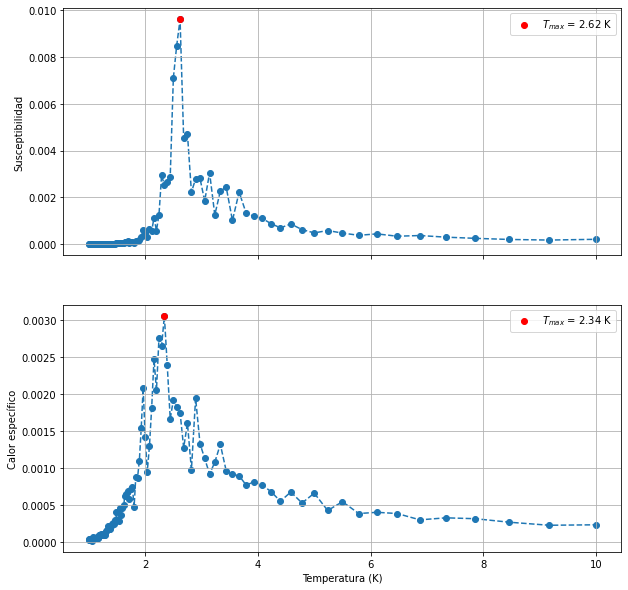

In [ ]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(10,10), sharex=True)
ax1.plot(data_t, data_chi, '--o', zorder=0)
ax1.set_ylabel('Susceptibilidad')
ax1.scatter(data_t[np.argwhere(data_chi == np.max(data_chi))[0][0]],
            data_chi[np.argwhere(data_chi == np.max(data_chi))[0][0]], c='r',
            label='$T_{max}$ = ' + f'{round(data_t[np.argwhere(data_chi == np.max(data_chi))[0][0]],2)} K', zorder=1)
ax1.grid()
ax1.legend()
ax2.plot(data_t, data_cv, '--o', zorder=0)
ax2.set_ylabel('Calor específico')
ax2.scatter(data_t[[np.argwhere(data_cv == np.max(data_cv))[0][0]]],
            data_cv[[np.argwhere(data_cv == np.max(data_cv))[0][0]]], c='r',
            label='$T_{max}$ = ' + f'{round(data_t[np.argwhere(data_cv == np.max(data_cv))[0][0]],2)} K', zorder=1)
ax2.grid()
ax2.legend()
ax2.set_xlabel('Temperatura (K)')
plt.show()

**Explicación:**

---

Aquí se permitió evolucionar la red desde un sistema de magnetización total 1 (spin-up) desde una temperatura de 1 K (tomando 5000000 de iteraciones tras un análisis previo) y llegado a la termalización se le permitió evolucionar unas 100000 tomando el promedio de la magnetización y de la energía del sistema desde la termalización hasta la iteración i-ésima. Luego, usando la red final se aumentó la temperatura y se realizó el mismo proceso, para 100 temperaturas entre 1 K y 100 K.

Las relaciones usadas para obtener la susceptibilidad magnética y el calor específico son las siguientes:

*   $\chi = \beta (\Delta m)^2$
*   $C_v = \beta (\Delta e)^2$

donde $\Delta e$ y $\Delta m$ corresponden a las desviaciones de los promedios de la energía por partícula y la magnetización por partícula.


# Correlaciones

La **función de correlación** se define como $g(r)=\langle s_{ij}s_{ij+r}\rangle-\langle s_{ij}\rangle\langle s_{ij+r}\rangle$, y se sabe que tiene la forma $g(r)=ae^{-r/\xi}$. A $\xi$ se lo conoce como la **longitud de correlación**, y es una función de la temperatura que, en el límite termodinámico, diverge a la temperatura crítica. El objetivo de esta sección es ver eso.

Lo primero que hay que hacer es definir dos funciones. La primera, **`cor(S)`**, devuelve un vector $c$ de $L/2$ componentes, donde $L$ es el lado de la red, cuya componente $r$ es el promedio de $s_{ij}s_{ij+r}$ sobre toda la red, es decir,

$c(r)=\frac{1}{L^2}\sum_{i,j=1}^Ls_{ij}s_{ij+r}.$

La segunda función, **`metropolis2(S,prob)`**, implementa el algoritmo de Metropolis, igual que hacía la función **`metropolis(S,prob)`**, pero esta vez, en lugar de devolver el nuevo estado, el incremento de la magnetización y el incremento de energía, devuelve el nuevo estado, el incremento de la magnetización y el incremento del vector $c$. Para definir estas dos funciones deberán prestar mucha atención a las condiciones de contorno periódicas, y tener en cuenta que $c(0)=1$ independientemente del estado, así que el incremento de $c(0)$ siempre es $0$.

In [ ]:
@njit
def metropolis(S,prob): #Aplica el algoritmo de Metropolis al estado S
  L = len(S)

  p = np.random.rand()
  i = np.random.randint(L)
  j = np.random.randint(L)

  dm = -S[i,j]*2/L**2
  delta_e = 2*S[i,j]*(S[(i+1)%L,j] + S[i-1,j] + S[i,(j+1)%L] + S[i,j-1])
  de = delta_e/L**2

  if delta_e <= 0:
    S[i,j]=-S[i,j]
    return(S,dm,de)
  elif delta_e == 4:
    if p > prob[0]:
      return(S,0,0)
    else:
      S[i,j]=-S[i,j]
      return(S,dm,de)
  elif delta_e == 8:
    if p > prob[1]:
      return(S,0,0)
    else:
      S[i,j]=-S[i,j]
      return(S,dm,de)

In [ ]:
@njit
def cor(S):
  L = len(S)
  A = np.ceil(L/2) # Longitud del vector c
  C_S = np.zeros(int(A))
  for r in range(A):
    for i in range(L):
      for j in range(L):
        C_S[r] += S[i,j]*S[i,(j+r)%L]
  return C_S/L**2

@njit
def metropolis2(S,prob): #Aplica el algoritmo de Metropolis al estado S
  L = len(S)
  A = int(np.ceil(L/2))

  p = np.random.rand()
  i = np.random.randint(L)
  j = np.random.randint(L)

  dm = -S[i,j]*2/L**2
  delta_e = 2*S[i,j]*(S[(i+1)%L,j] + S[i-1,j] + S[i,(j+1)%L] + S[i,j-1])

  c_o = cor(S)
  S[i,j] = -S[i,j] # Cambio el spin i,j-ésimo para calcular su respectivo vector correlación
  c_n = cor(S)
  dc = c_n - c_o

  if delta_e <= 0:
    return(S,dm,dc)
  elif delta_e == 4:
    if p > prob[0]:
      S[i,j] = -S[i,j] # Devuelvo la red a su estado original puesto que no ocurre cambio alguno
      return(S,0,np.zeros(A))
    else:
      return(S,dm,dc)
  elif delta_e == 8:
    if p > prob[1]:
      S[i,j] = -S[i,j] # Devuelvo la red a su estado original puesto que no ocurre cambio alguno
      return(S,0,np.zeros(A))
    else:
      return(S,dm,dc)

**Explicación:**

---

Primero definimos ``cor(S)`` y luego calculamos el valor para una posicion aleatorio de S en 2 ocasiones: previo a dar vuelta el spin de la posición seleccionada y posterior a dar vuelta dicho spin. Estos resultados se almacenan en las variables ``c_o`` y ``c_n `` respectivamente para hacer la resta entre ambos que nos va a dar el incremento de la correlacion (``dc``).

Luego planteamos las distintas probabilidades de manera muy similar a Metropolis y en los casos no favorables a dar vuelta el spin, devolvemos la red a su estado original, e indicamos que el incremento en correlacion es nulo.

El estado S y el incremento de la magnetizacion dm se obtienen de la misma manera que en Metropolis.

Ahora usamos las funciones que acabamos de definir para calcular la función de correlación a tres temperaturas distintas. Ajustamos los datos obtenidos con una función de la forma $a e^{-r/\xi}$, y de ahí obtenemos la longitud de correlación a esas tres temperaturas.

Longitud de correlacion:
T=1.5 => 0.37293757344201656
T=2.3 => 1.129514089891668
T=3 => 1.1521351021171566


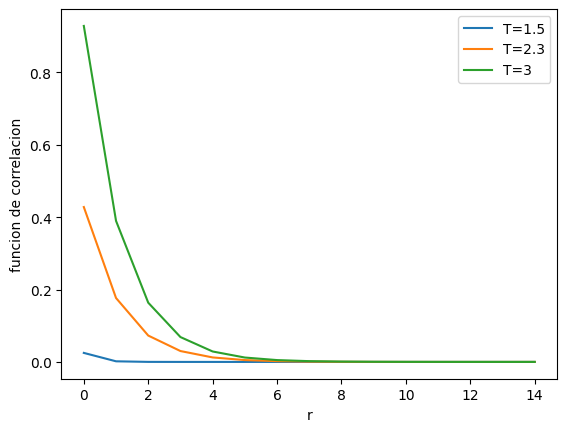

In [ ]:
L=30

nequilibrio=1000
npromedio=50000

l=int(L/2) #numero de componentes del vector c
m=np.zeros(npromedio) #magnetizacion en funcion del paso
c=np.zeros((l,npromedio)) #vector c en funcion del paso

erres=np.arange(l) #dominio de la funcion de correlacion
def fitcor(r,a,xi): #funcion con la que vamos a ajustar
  return a*np.exp(-r/xi)

S=np.ones((L,L),dtype=int)

print('Longitud de correlacion:')

for T in [1.5,2.3,3]:

  beta=1/T

  prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

  #Termalizamos con la funcion metropolis(S,prob), que es mas rapida
  for n in range(nequilibrio):
    S,dm,de=metropolis(S,prob)

  m[0]=np.mean(S)
  c[:,0]=cor(S)

  for n in range(1,npromedio):
    S,dm,dc=metropolis2(S,prob)
    m[n]=m[n-1]+dm
    c[:,n]=c[:,n-1]+dc

  mmedia=np.mean(abs(m))
  correlacion=np.mean(c,axis=1)-mmedia**2 #funcion de correlacion

  #Ajustamos:
  parametros,covarianza=curve_fit(fitcor,erres,correlacion)
  #(la funcion curve_fit devuelve el mejor valor de los parametros
  #y tambien la covarianza, que no vamos a usar)

  print('T={} => {}'.format(T,parametros[1]))

  plt.plot(erres,fitcor(erres,parametros[0],parametros[1]),label='T={}'.format(T))

plt.xlabel('r')
plt.ylabel('funcion de correlacion')
plt.legend()
plt.show()

Por último, hay que barrer un rango de temperaturas que incluya la crítica y obtener un gráfico de la longitud de correlación en función de la temperatura.

In [ ]:
data_lc_b = np.loadtxt('datos_t_lc_30_b.txt', unpack = True)
x = data_lc_b[:,0]
y = data_lc_b[:,1]

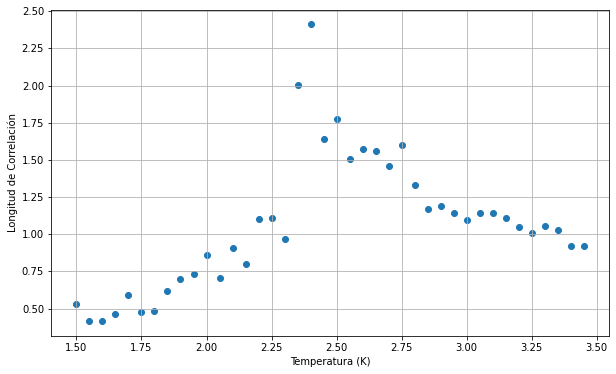

In [ ]:
fig = plt.figure(figsize=(10,6))

plt.scatter(x,y)
plt.xlabel('Temperatura (K)')
plt.ylabel('Longitud de Correlación')
plt.grid()
plt.show()

**Explicación:**

---

Se realizo un procedimiento de barrido a varias temperaturas entre 1.5 K y 3.5 K análogo  al realizado para susceptibilidad magnética y calor especifico. En este caso ajustamos la función de correlación para conseguir el valor de $\xi$ para cada una de las temperaturas.

# Temperatura crítica

La teoría de **finite-size scaling** (Fisher y Barber, Physical Review Letters 28, 1972) muestra que, para una red de Ising bidimensional de lado $L$, el pico de la susceptibilidad ocurre a una temperatura $T_c(L)$ dada por

$$T_c(L)=T_c+\frac{a}{L},$$

donde $T_c$ es la temperatura crítica del sistema en el límite termodinámico y $a$ es una constante. Lo que deben hacer en esta sección es determinar $T_c(L)$ para $L=15,30,60,120$ con una precisión aproximada de $0.01$, graficar en función de $1/L$, ajustar los puntos a una recta y de ahí obtener una estimación para la temperatura crítica.

In [ ]:
G = []
H = []

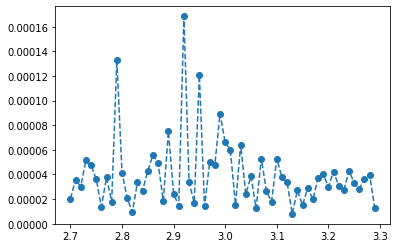

2.9199999999999955


In [ ]:
# Ls = [15,30,60,120]
# ts = [[2.48,2.54],[2.25,2.45],[2.25,2.45],[3.45,3.56]]

# Ls = [15,30,60,120]
# ts = [[2.3,2.5],[2.2,2.4],[2.8,3.0],[2.9,3.1]]

Ls = [120]
ts = [[2.7, 3.3]]
nequilibrio=10000000 #Este valor lo decidimos en base a lo anterior
npromedio=100000 #Numero de pasos tentativo para calcular promedios

for k in range(len(Ls)):
  L = Ls[k]
  beta = 1/np.arange(ts[k][0], ts[k][1], 0.01)
  chi = np.zeros(len(beta))
  S=np.ones((L,L),dtype=int) #Estado inicial
  # S=2*np.random.randint(2,size=(L,L))-1

  for i in range(len(beta)):

    b = beta[i]
    # Sin termalizar
    prob=np.array([np.exp(-4*b),np.exp(-8*b)])
    for n in range(nequilibrio):
      S,dm,de=metropolis(S,prob) #Termalizamos

    m=np.zeros(npromedio)
    e=np.zeros(npromedio) #Magnetizacion y energia por particula en funcion del paso
    m[0]=np.mean(S)
    e[0]=h(S)

    # Post-termalización
    mmedia=[m[0]]
    emedia=[e[0]] #Valores medios en funcion del numero de pasos para promediar

    for n in range(1,npromedio):
      S,dm,de=metropolis(S,prob)
      m[n]=m[n-1]+dm
      e[n]=e[n-1]+de

    chi[i] = (b * (np.std(m)**2))

  plt.plot(1/beta,chi, '--o')
  plt.show()

  # G.append([L,1/beta[np.argwhere(chi == np.max(chi))][0][0]])
  # H.append([1/beta[np.argwhere(chi == np.max(chi))-1][0][0],1/beta[np.argwhere(chi == np.max(chi))+1][0][0]])

**Explicación:**

---

Para cada valor de L calculamos $\chi_T = \beta(\Delta m)^2$ haciendo barridos a diferentes temperaturas. Nos basamos en los puntos anteriores para saber cuántas iteraciones tomar antes de operar.

Para encontrar la temperatura critica con precisión de 0.01 desconociendo el rango en el que se encuentra consumiría una cantidad gigantezca de tiempo (estimado poco más de 12 horas para barrer entre 0 y 8). Por este motivo, hicimos barridos gruesos de 20 puntos entre 0 y 8, y luego detectamos en qué intervalo podíamos afirmar con certeza que se encontraría la temperatura crítica para cada L. Una vez hecho esto refinamos la búsqueda a otros 20 puntos en ese intervalo.

Fuimos repitiendo este proceso lo que achico la cantidad de evaluaciones de 800 a 60. Una vez que nos pasaríamos de la precisión deseada hicimos una evaluación de 11 puntos lo que nos llevo a los deseados 0.01.

Los datos obtenidos pueden observarse en el array G de la siguiente celda.

In [ ]:
G = [[15,2.09],[30,2.49],[60,2.71],[120,2.92]]

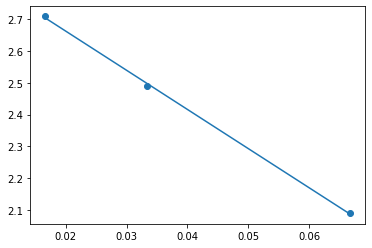

In [ ]:
x = 1/np.array(G[:-1])[:,0]
y = np.array(G[:-1])[:,1]

lr = linregress(x,y)

plt.scatter(x,y)
plt.plot(x, lr.slope*x + lr.intercept)
plt.show()

# Discusión

---
Datos conocidos de $T_c$

*   Onsager => 2.27 K
*   Bragg-Williams => 2.89 K

Datos obtenidos

*   $\chi$ (L=30) => 2.62 K
*   $C_v$ (L=30) => 2.34 K
*   $\xi$ (para todo L) => 2.4 K
*   Ajuste lineal => 2.91 K
---

Los valores obtenidos de temperatura critica se encuentran entre 2.34 K y 2.91 K dependiendo del metodo utilizado. Si nos basamos en cual metodo resulto arrojar un valor mas cercano al exacto, el cálculo en base al $C_v$ dio una temperatura crítica 0.11 K por encima de la solución de onsager. El ajuste lineal resultó el mas inexacto.

Por otro lado en comparación con la aproximación de Braggs Williams, todos los datos obtenidos exceptuando al ajuste lineal dan cuenta de una temperatura crítica por debajo de la aproximación. Resulta logico que primeros vecinos estime una temperatura mayor dado que ignora las interacciónes entre todos los spines (ignorando las fluctuaciones). Campo medio es una aproximación incluso mas gruesa dado que no solo ignoramos primeros vecinos sino que tambien se generaliza el estado de la red haciendo "como si fuese un campo magnetico externo". Por esto es razonable que el modelo de ising se comporte como un "punto medio" entre Braggs Williams y la solución exacta de Onsager.

El ajuste lineal falla bastante mas que los otros métodos, lo cual atribuimos al hecho de que los puntos generados fluctúan muchísimo entre realización y realización de la celda (mucha fluctuación de los valores obtenidos). Asi como obtuvimos 2.91 K, si se vuelve a correr el codigo bien podríamos obtener un valor 0.50 K menor.